In [2]:
import pandas as pd
from jetstream_hugo.jet_finding import *
from jetstream_hugo.definitions import *
from jetstream_hugo.plots import *
from jetstream_hugo.clustering import *
from jetstream_hugo.data import *

import colormaps

%load_ext autoreload
%autoreload 2
%matplotlib inline

/storage/homefs/hb22g102/mambaforge/envs/env11/lib/python3.11/site-packages/libpysal/cg/alpha_shapes.py:38: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit
/storage/homefs/hb22g102/mambaforge/envs/env11/lib/python3.11/site-packages/libpysal/cg/alpha_shapes.py:164: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit
/storage/homefs/hb22g102/mambaforge/envs/env1

In [3]:
exp_s = Experiment(
    "ERA5", "s", "6H", (1940, 2023), [5, 6, 7, 8, 9], -60, 70, 25, 85, 250, None, None, None
)
da_s = exp_s.da
exp_s_low = Experiment(
    "ERA5", "s", "6H", (1940, 2023), [5, 6, 7, 8, 9], -60, 70, 25, 85, 700, None, None, None
)
exp_T = Experiment(
    "ERA5", "t", "6H", "all", "JJA", -60, 70, 25, 85, 250, 'hourofyear', {'hourofyear': ('win', 4 * 10)}, None,
)
da_T = exp_T.da

In [4]:
da_pvs, da_pvs_anom, da_pvs_anom_normd = open_pvs(da_s)

Events to xarray
[########################################] | 100% Completed | 13.20 s
[########################################] | 100% Completed | 3.98 sms
[########################################] | 100% Completed | 6.69 sms


: 

: 

In [5]:
net, centers, labels = exp_s.compute_som(
    6,
    6,
    200,
    return_type=ADJUST_REALSPACE,
    train_kwargs=dict(train_algo="batch", epochs=1000),
)

n_samples = net.compute_populations()
coords = net.neighborhoods.coordinates
mask = labels_to_mask(labels)
mask_none = mask[:, 0]
mask = mask[:, 1:]
center_none = centers[0]
centers = centers[1:]
centers_all_jets = find_all_jets(centers, height=25, cutoff_blobs=750, cutoff_jets=1200, chunksize=3)
centers_props = compute_all_jet_props(centers_all_jets, centers)
centers_props_ds = (
    xr.concat([xr.Dataset.from_dataframe(pd.DataFrame(centers_props[i])).rename(index='jet') for i in range(len(centers_props))], dim='center').assign_coords(center=np.arange(net.n_nodes))
)
bmus_da = xr.DataArray(net.bmus, coords={'time': da_s.time.values})
labels_daily = bmus_da.interp(coords={'time': da_T.time.values}, method='nearest').astype(int).values
mask_daily = labels_to_mask(labels_daily)
populations = (centers.ratios.values * len(da_s.time)).astype(int)
s_to_T = np.isin(da_s.time.values, da_T.time.values)
s_to_pvs = np.isin(da_s.time.values, da_pvs.time.values)

2024-01-11 16:01:15.955 | INFO     | simpsom.network:__init__:116 - Periodic Boundary Conditions active.
2024-01-11 16:01:15.963 | INFO     | simpsom.network:__init__:127 - Hexagonal topology.
2024-01-11 16:01:16.007 | INFO     | simpsom.network:_set_weights:223 - The weights will be loaded from file
100%|██████████| 36/36 [00:00<00:00, 250.03it/s]


In [1]:
da_pvs.nbytes

NameError: name 'da_pvs' is not defined

In [6]:
clim_pvs = compute_clim(da_pvs, 'hourofyear', flox=False)

: 

: 

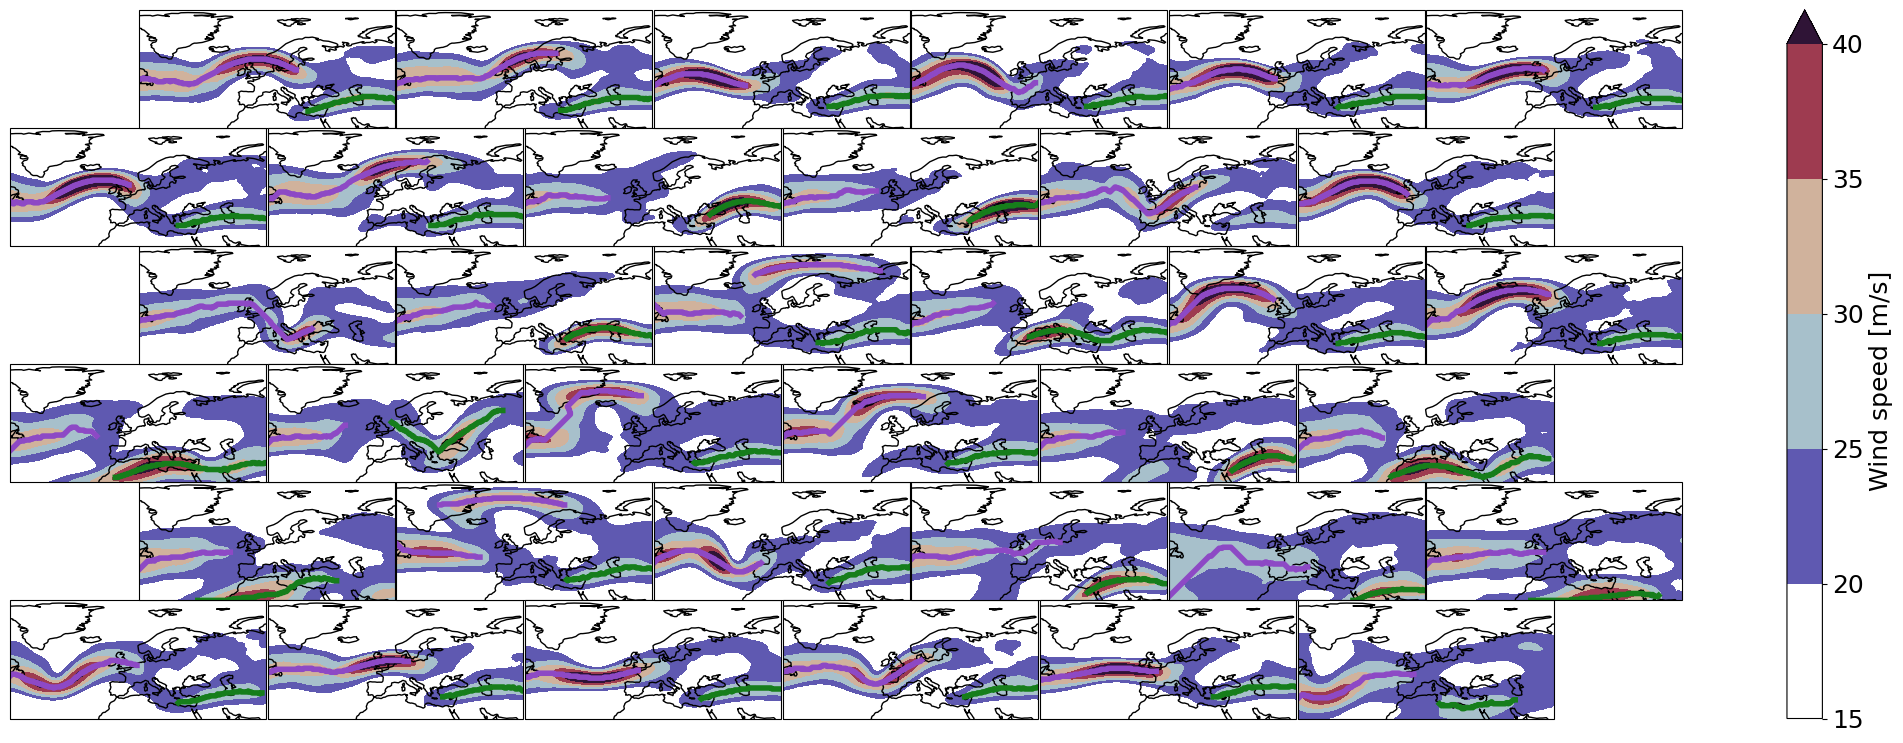

In [ ]:
clu = Clusterplot(net.width, net.height, exp_s.region, honeycomb=True)
_ = clu.add_contourf(
    centers,
    cmap='twilight_shifted',
    start=15,
    nlevels=6,
    transparify=1,
    cbar_label="Wind speed [m/s]",
)

is_polar = centers_props_ds['is_polar']
for ax, is_pol, jets in zip(clu.axes, is_polar.values, centers_all_jets):
    for j, (jet, is_p) in enumerate(zip(jets, is_pol)):
        x, y, s = jet.T
        ax.plot(x, y, color=COLORS5[int(is_p)], lw=4)
plt.savefig(f'{FIGURES}/som_composites/SOM_wind_speed.png')


  3%|▎         | 1/36 [00:00<00:03,  9.25it/s]

100%|██████████| 36/36 [00:50<00:00,  1.39s/it]


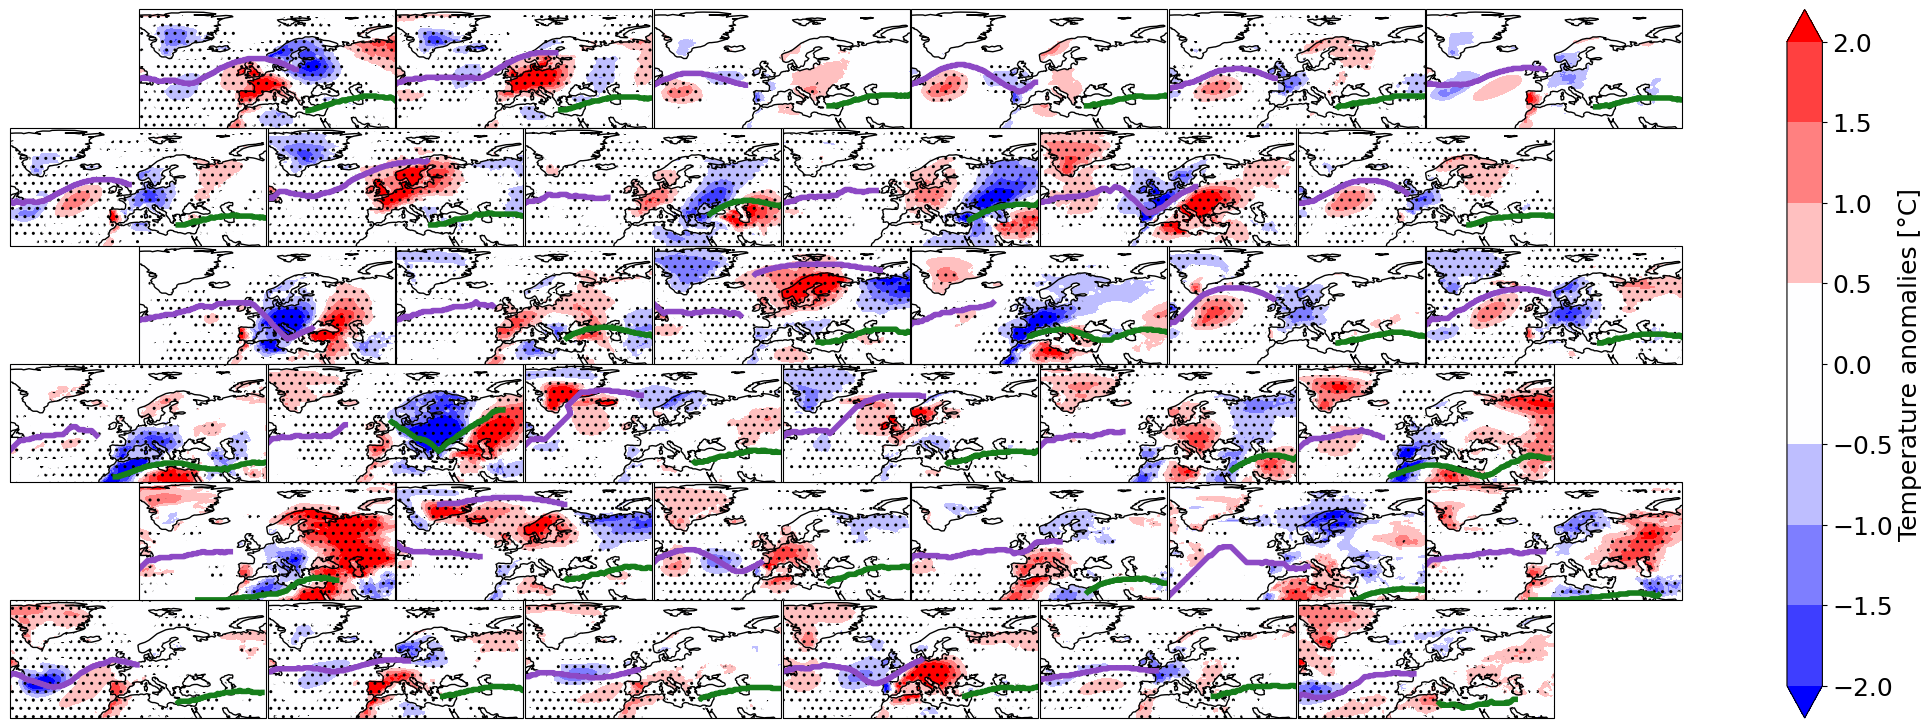

In [6]:
clu = Clusterplot(net.width, net.height, exp_T.region, honeycomb=True)
for ax in clu.axes:
    ax.autoscale(False)
clu.add_any_contour_from_mask(
    da_T, mask[s_to_T], "contourf", stippling=True, cbar_label="Temperature anomalies [°C]", cmap='bwr'
)
is_polar = centers_props_ds['is_polar']
for ax, is_pol, jets in zip(clu.axes, is_polar.values, centers_all_jets):
    for j, (jet, is_p) in enumerate(zip(jets, is_pol)):
        x, y, s = jet.T
        ax.plot(x, y, color=COLORS5[int(is_p)], lw=4)
plt.savefig(f'{FIGURES}/som_composites/SOM_temp.png')


100%|██████████| 36/36 [03:23<00:00,  5.64s/it]


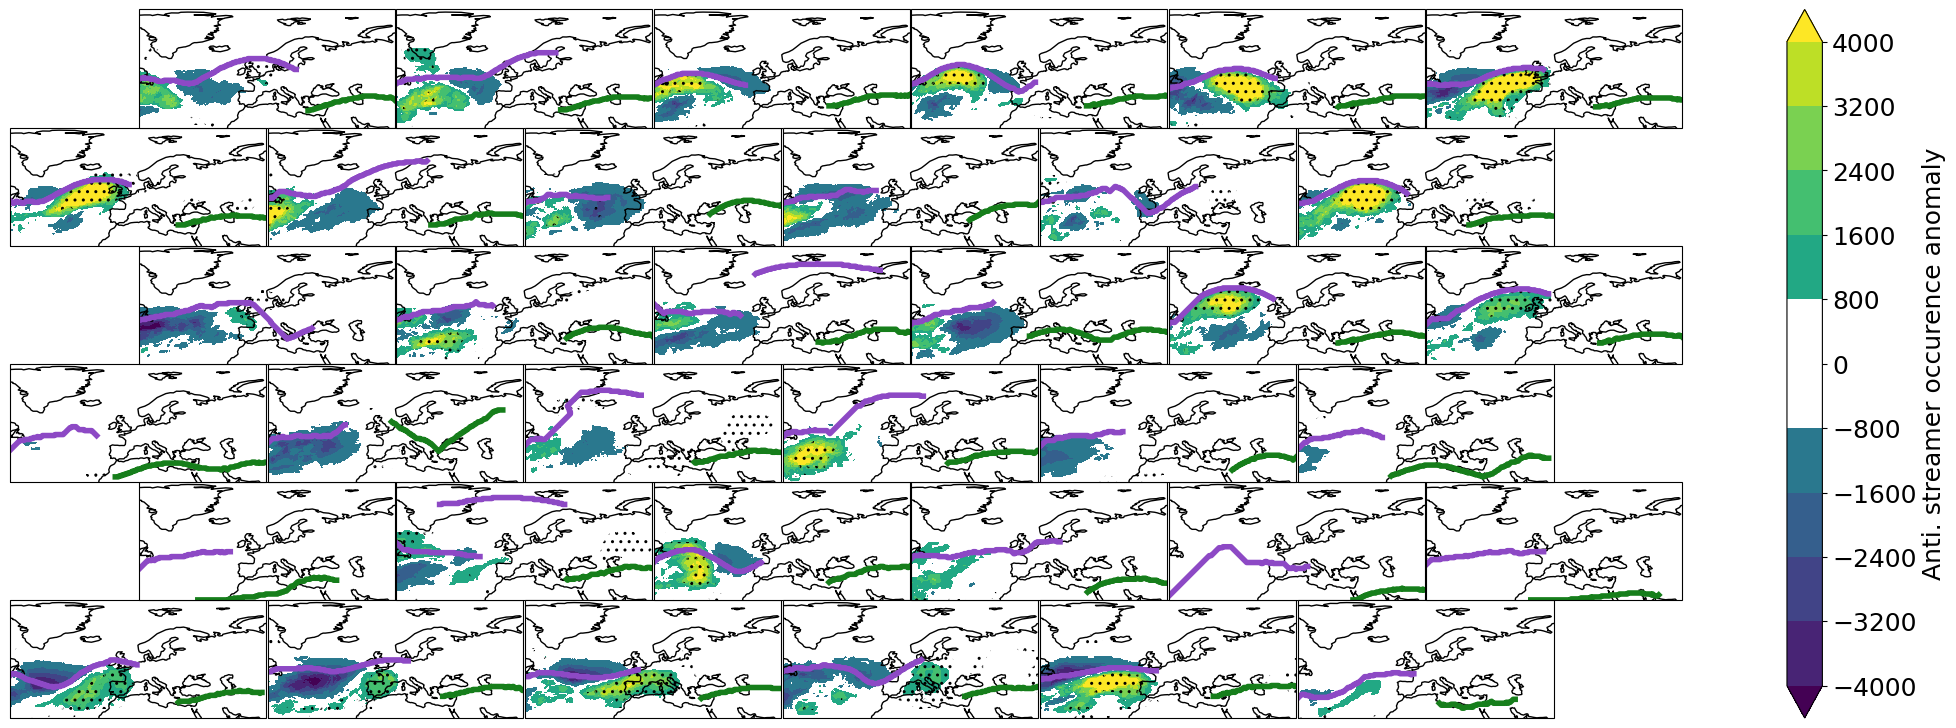

In [12]:
clu = Clusterplot(net.width, net.height, exp_T.region, honeycomb=True)
for ax in clu.axes:
    ax.autoscale(False)
    
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    clu.add_any_contour_from_mask(
        da_pvs_anom.sel(type='anti'), mask[s_to_pvs], "contourf", stippling=True, cbar_label="Anti. streamer occurence anomaly", transparify=1, cmap='viridis', q=0.995
    )
is_polar = centers_props_ds['is_polar']
for ax, is_pol, jets in zip(clu.axes, is_polar.values, centers_all_jets):
    for j, (jet, is_p) in enumerate(zip(jets, is_pol)):
        x, y, s = jet.T
        ax.plot(x, y, color=COLORS5[int(is_p)], lw=4)
clu.fig.savefig(f'{FIGURES}/som_composites/SOM_apvs.png')

In [17]:
da_pvs_anom_normd

100%|██████████| 36/36 [00:03<00:00, 11.91it/s]


OverflowError: cannot convert float infinity to integer

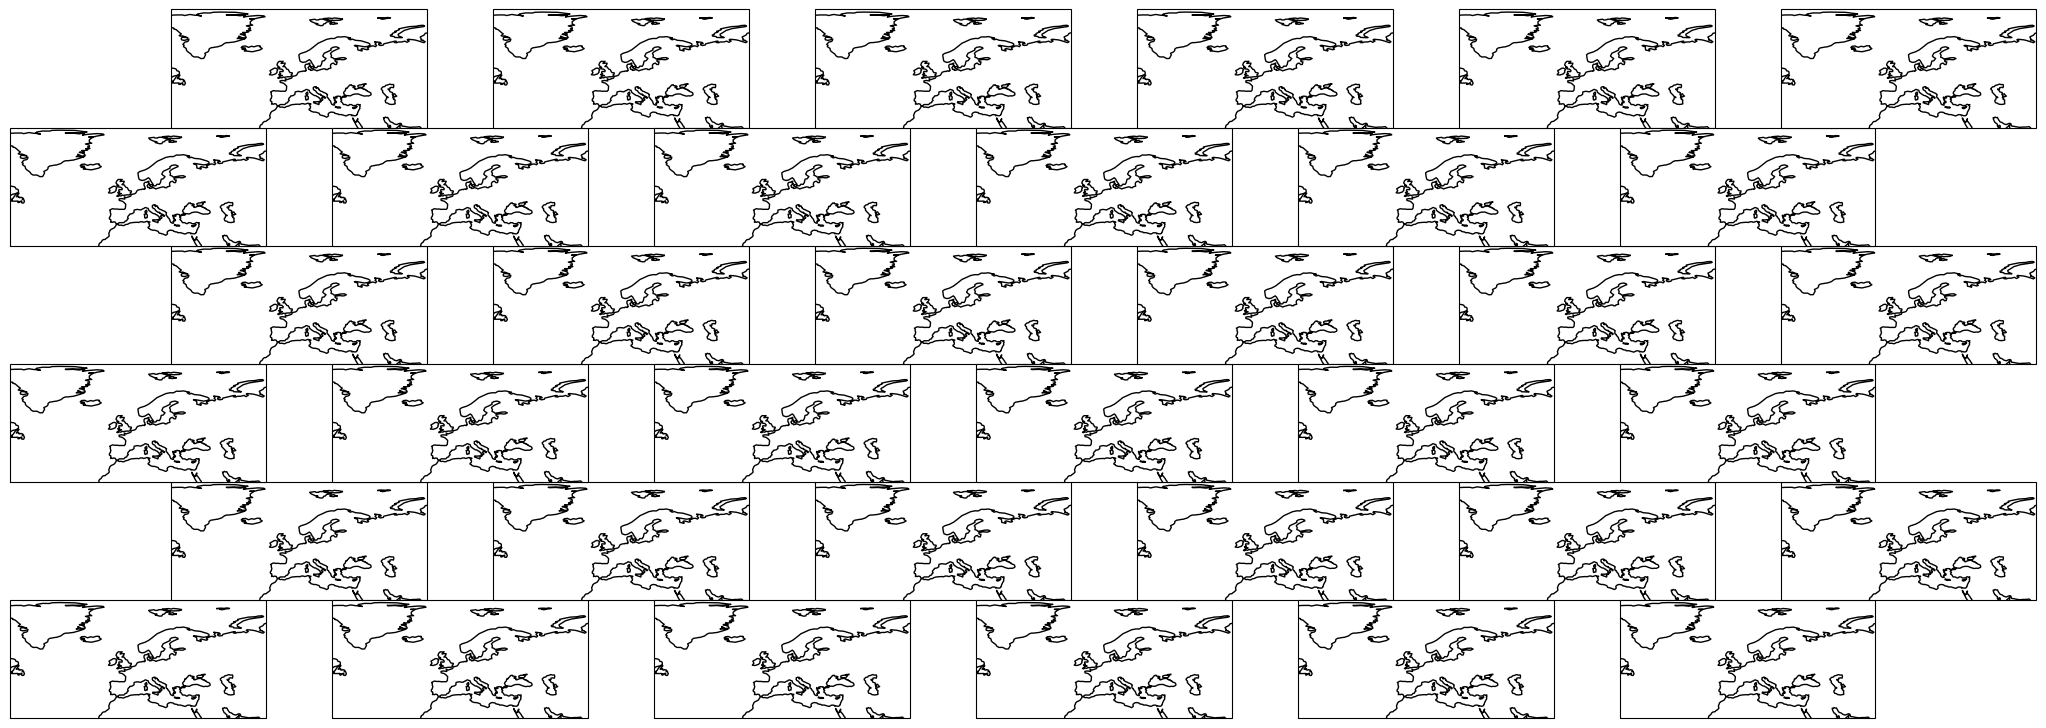

In [16]:
clu = Clusterplot(net.width, net.height, exp_T.region, honeycomb=True)
for ax in clu.axes:
    ax.autoscale(False)
    
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    clu.add_any_contour_from_mask(
        da_pvs_anom_normd.fillna(0).sel(type='anti'), mask[s_to_pvs], "contourf", stippling=True, cbar_label="Anti. streamer occurence anomaly", transparify=1, cmap='viridis', q=0.995
    )
is_polar = centers_props_ds['is_polar']
for ax, is_pol, jets in zip(clu.axes, is_polar.values, centers_all_jets):
    for j, (jet, is_p) in enumerate(zip(jets, is_pol)):
        x, y, s = jet.T
        ax.plot(x, y, color=COLORS5[int(is_p)], lw=4)
clu.fig.savefig(f'{FIGURES}/som_composites/SOM_apvs_normd.png')

100%|██████████| 36/36 [00:06<00:00,  5.57it/s]


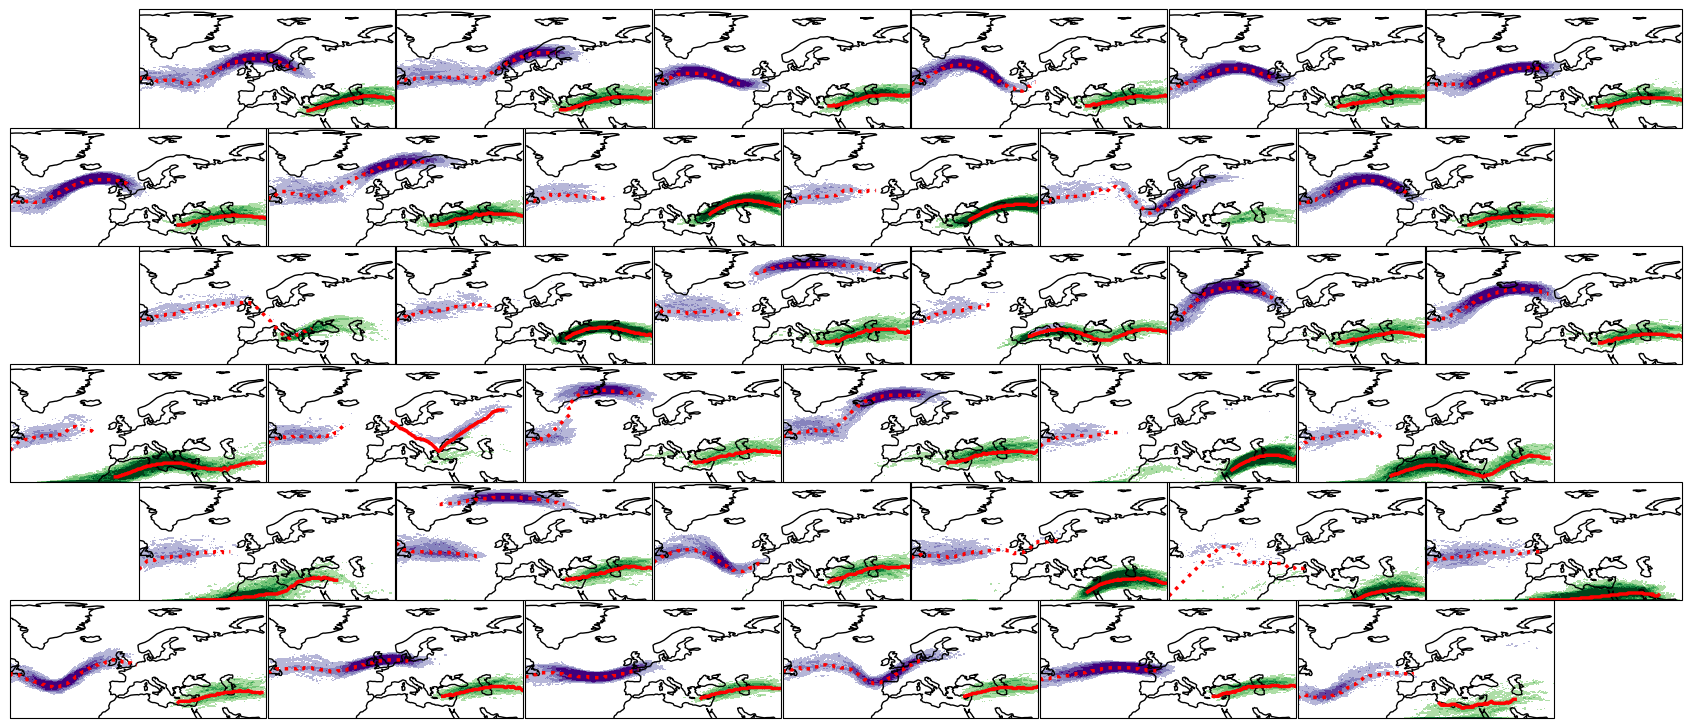

In [5]:
clu = Clusterplot(net.width, net.height, exp_T.region, honeycomb=True)
for ax in clu.axes:
    ax.autoscale(False)
_ = clu.add_any_contour_from_mask(
    da_jet_pos[:, 0] / da_jet_pos[:, 0].max(), mask, cbar_label="Subtropical jet occurence", transparify=2, cmap='Greens', draw_cbar=False,
)
_ = clu.add_any_contour_from_mask(
    da_jet_pos[:, 1] / da_jet_pos[:, 1].max(), mask, cbar_label="Polar jet occurence", transparify=2, cmap='Purples', draw_cbar=False,
)
linestyles = ['solid', 'dotted']
is_polar = centers_props_ds['is_polar']
for ax, is_pol, jets in zip(clu.axes, is_polar.values, centers_all_jets):
    for j, (jet, is_p) in enumerate(zip(jets, is_pol)):
        x, y, s = jet.T
        ax.plot(x, y, color='red', ls=linestyles[int(is_p)], lw=2.5)

clu.fig.set_size_inches(*(clu.fig.get_size_inches() * np.array([0.8, 1])))
clu.fig.savefig(f'{FIGURES}/som_composites/SOM_jet_pos.png')